In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#mcfile = uproot.open("/pnfs/dune/scratch/users/yinrui/MC0_211205/pduneana_MC.root:pduneana")
#datafile = uproot.open("/pnfs/dune/scratch/users/yinrui/data_211203/pduneana_data.root:pduneana")
mcfile = uproot.open("/dune/data/users/kyang/pduneana_production/mc/whole_mc.root:pduneana")
datafile = uproot.open("/dune/data/users/kyang/pduneana_production/data/whole_data.root:pduneana")

/dune/app/users/yinrui/env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:209: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(
/dune/app/users/yinrui/env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:209: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


MC selected events: 2782 	Data selected events: 4075
Cut: (reco_beam_vertex_michel_score/reco_beam_vertex_nHits>0.8)&(reco_beam_calo_endZ>240)&(beam_inst_P>0)&(beam_inst_P<1.4)


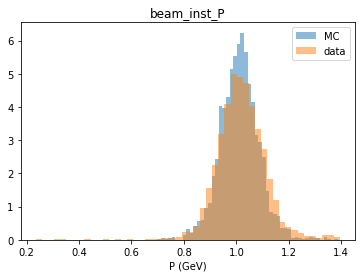

In [2]:
branches = ["beam_inst_P", "reco_beam_calo_startX", "reco_beam_calo_startY", "reco_beam_calo_startZ", "reco_beam_calo_endX", "reco_beam_calo_endY", "reco_beam_calo_endZ"]
cut = "(reco_beam_vertex_michel_score/reco_beam_vertex_nHits>0.8)&(reco_beam_calo_endZ>240)&(beam_inst_P>0)&(beam_inst_P<1.4)"

mcevt = mcfile["beamana"].arrays(branches, cut)
dataevt = datafile["beamana"].arrays(branches, cut)
mcP = mcevt["beam_inst_P"]
dataP = dataevt["beam_inst_P"]
print("MC selected events:", len(mcP), "\tData selected events:", len(dataP))
print("Cut:", cut)
plt.hist(mcP,density=True,bins=50,alpha=0.5,label="MC")
plt.hist(dataP,density=True,bins=50,alpha=0.5,label="data")
plt.legend()
plt.title("beam_inst_P")
plt.xlabel("P (GeV)")
plt.show()

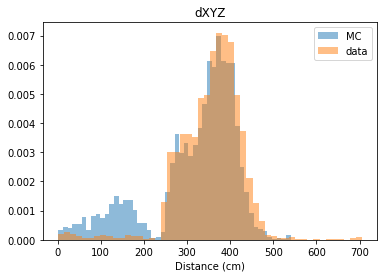

In [3]:
MC_dXYZ = np.sqrt((mcevt.reco_beam_calo_endX-mcevt.reco_beam_calo_startX)**2 + (mcevt.reco_beam_calo_endY-mcevt.reco_beam_calo_startY)**2 + (mcevt.reco_beam_calo_endZ-mcevt.reco_beam_calo_startZ)**2)
data_dXYZ = np.sqrt((dataevt.reco_beam_calo_endX-dataevt.reco_beam_calo_startX)**2 + (dataevt.reco_beam_calo_endY-dataevt.reco_beam_calo_startY)**2 + (dataevt.reco_beam_calo_endZ-dataevt.reco_beam_calo_startZ)**2)
plt.hist(MC_dXYZ,density=True,bins=50,alpha=0.5,label="MC")#, range=[200,600])
plt.hist(data_dXYZ,density=True,bins=50,alpha=0.5,label="data")#, range=[200,600])
plt.legend()
plt.title("dXYZ")
plt.xlabel("Distance (cm)")
plt.show()

In [4]:
mu0 = 1.013 # MC
sigma0 = 0.06598
deno = np.exp(-(mcP - mu0)**2/2/sigma0**2)
muu = 1.025 # data
sigmaa = 0.07344
nbins = 30; xmin = 240; xmax = 540
datahist, bin_edges = np.histogram(data_dXYZ, bins=nbins, range=[xmin, xmax])

def getChi2(mu=muu, sigma=sigmaa):
    numo = np.exp(-(mcP - mu)**2/2/sigma**2)
    weight = numo/deno
    MChist, _ = np.histogram(MC_dXYZ, bins=nbins, range=[xmin, xmax], weights=weight, density=True)
    MChist *= len(data_dXYZ)
    chi2 = (datahist - MChist)**2/np.maximum(np.sqrt(datahist),1)
    return np.sum(chi2)/(nbins-1)

In [5]:
mu_list = np.linspace(0.99, 1.06, 100)
sigma_list = np.linspace(0.05, 0.09, 100)
mm, ss = np.meshgrid(mu_list, sigma_list)
Chi2 = np.zeros_like(mm)
for i in range(len(mm)):
    for j in range(len(mm[0])):
        Chi2[i,j] = getChi2(mm[i,j], ss[i,j])

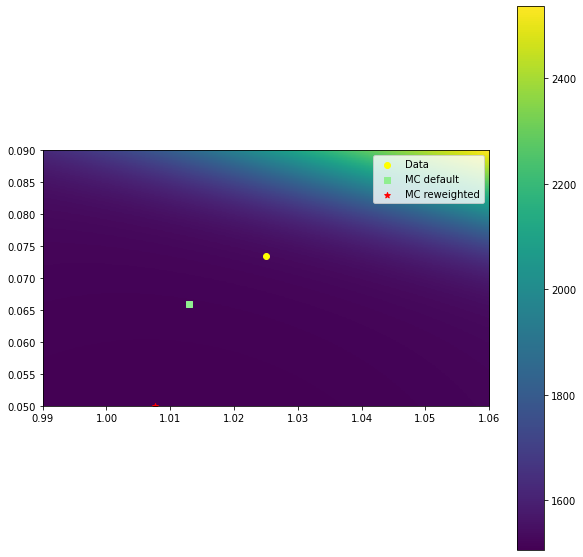

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(Chi2,extent = [0.99,1.06,0.05,0.09],origin="lower")
plt.colorbar()
plt.scatter([muu], [sigmaa], color="yellow", marker="o", label="Data")
plt.scatter([mu0], [sigma0], color="lightgreen", marker="s", label="MC default")
minidx = np.where(Chi2 == np.min(Chi2))
mur = mm[minidx]
sigmar = ss[minidx]
plt.scatter(mur, sigmar, color="r", marker="*", label="MC reweighted")
plt.legend()
plt.show()

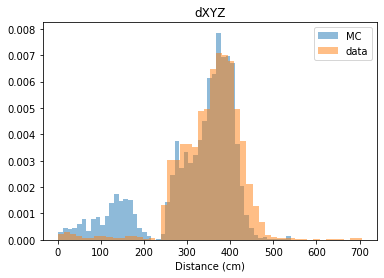

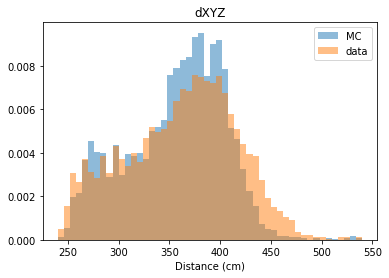

In [7]:
plt.hist(MC_dXYZ,density=True,bins=50,alpha=0.5,label="MC",weights=np.exp(-(mcP-mur)**2/2/sigmar**2)/deno)
plt.hist(data_dXYZ,density=True,bins=50,alpha=0.5,label="data")
plt.legend()
plt.title("dXYZ")
plt.xlabel("Distance (cm)")
plt.show()

plt.hist(MC_dXYZ,density=True,bins=50,alpha=0.5,label="MC",weights=np.exp(-(mcP-mur)**2/2/sigmar**2)/deno, range=[xmin, xmax])
plt.hist(data_dXYZ,density=True,bins=50,alpha=0.5,label="data", range=[xmin, xmax])
plt.legend()
plt.title("dXYZ")
plt.xlabel("Distance (cm)")
plt.show()